In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error

from scipy import linalg
import yfinance as yf
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate


## Question 1A: Kalman Filters in Time Series Analysis

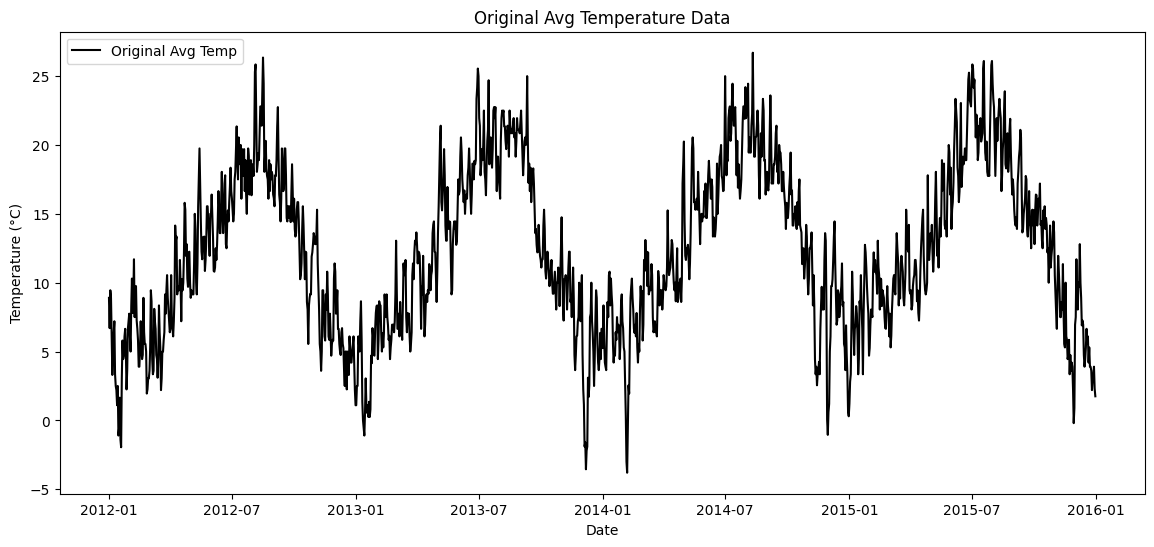

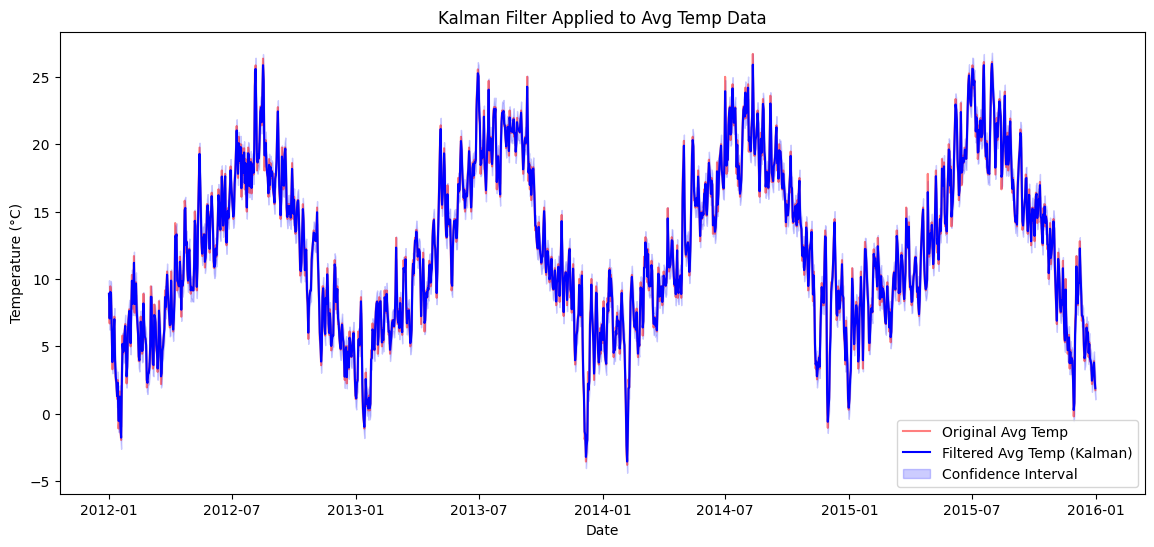

Performance Metrics:
Mean Squared Error (MSE): 0.1111
Root Mean Squared Error (RMSE): 0.3334
Mean Absolute Error (MAE): 0.2635


In [6]:
class KalmanFilter:
    def __init__(self, alpha, q, r, initial_state, initial_variance):
        """
        Initializes the Kalman filter with parameters.
        
        Args:
            alpha (float): State transition coefficient.
            q (float): Process noise standard deviation.
            r (float): Measurement noise standard deviation.
            initial_state (float): Initial state estimate.
            initial_variance (float): Initial error covariance.
        """
        self.alpha = alpha
        self.q = q
        self.r = r
        self.mu = initial_state
        self.sigma = initial_variance

    def filter(self, data):
        """
        Applies the Kalman filter to the input data.
        
        Args:
            data (np.array): The data array to filter.
        
        Returns:
            mu_filtered (np.array): Array of filtered state estimates.
            sigma_filtered (np.array): Array of filtered variances.
        
        TODO:
        - Implement the prediction and update steps of the Kalman filter.
        """
        T = len(data)
        mu_filtered = np.zeros(T)
        sigma_filtered = np.zeros(T)
        mu_filtered[0] = self.mu
        sigma_filtered[0] = self.sigma

        for t in range(1, T):
            # TODO: Implement prediction step
            mu_prior = self.alpha *  mu_filtered[t-1] # Replace with: μ_prior_t = α * μ_t-1
            sigma_prior = self.q**2 + (self.alpha**2) * (sigma_filtered[t-1])   # Replace with: σ_prior_t = q^2 + (α^2) * σ_t-1

            # TODO: Implement update step
            K = (sigma_prior) / (sigma_prior + self.r**2)  # Replace with: σ_prior_t / (σ_prior_t + r^2)
            mu_filtered[t] = mu_prior + K * (data[t] -  mu_prior)  # Replace with: μ_t = μ_prior_t + K_t * (data_t - μ_prior_t)
            sigma_filtered[t] = (1- K)* sigma_prior  # Replace with: σ_t = (1 - K_t) * σ_prior_t

        return mu_filtered, sigma_filtered

    def plot_results(self, dates, data, mu_filtered, sigma_filtered):
        """
        Plots the original and filtered data along with the confidence interval.
        
        Args:
            dates (pd.Index): Date index for the data.
            data (np.array): Original data.
            mu_filtered (np.array): Filtered state estimates.
            sigma_filtered (np.array): Filtered variances.
        """
        plt.figure(figsize=(14, 6))
        plt.plot(dates, data, label='Original Avg Temp', color='red', alpha=0.5)
        plt.plot(dates, mu_filtered, label='Filtered Avg Temp (Kalman)', color='blue')
        plt.fill_between(dates, mu_filtered + sigma_filtered, mu_filtered - sigma_filtered, color='blue', alpha=0.2, label='Confidence Interval')
        plt.title('Kalman Filter Applied to Avg Temp Data')
        plt.xlabel('Date')
        plt.ylabel('Temperature (°C)')
        plt.legend()
        plt.show()

def evaluate_kalman_performance(actual_data, predicted_data):
    # Calculate performance metrics
    mse = mean_squared_error(actual_data, predicted_data)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_data, predicted_data)
    
    # Print performance metrics
    print("Performance Metrics:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")

    
    return mse, rmse, mae


# Main function with TODOs for students to complete
if __name__ == "__main__":
    # TODO: Load the dataset and preprocess it
    weather_df = pd.read_csv('seattle-weather.csv', parse_dates=['date'], index_col='date') # TODO Load the data using the 'parse_dates' and 'index_col' arguments
    weather_df = weather_df[['temp_max', 'temp_min', 'weather']].dropna()  # TODO: Select 'temp_max', 'temp_min', and 'weather' columns and drop NaN values
    
    # Calculate the average temperature
    weather_df['temp_avg'] = (weather_df['temp_max'] + weather_df['temp_min']) / 2  # TODO: Calculate the average temperature 
    
    # Plot the original average temperature data
    plt.figure(figsize=(14, 6))
    plt.plot(weather_df.index, weather_df['temp_avg'], label='Original Avg Temp', color='black')
    plt.title('Original Avg Temperature Data')
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.show()

    # TODO: Set Kalman filter parameters
    alpha = 1  # Replace with appropriate value
    q = 2  # Replace with appropriate value
    r = 1  # Replace with appropriate value
    initial_state = weather_df['temp_avg'].values[0]  # Initial state estimate
    initial_variance = 1  # Initial error covariance

    # Initialize the Kalman filter
    kf = KalmanFilter(alpha, q, r, initial_state, initial_variance)

    # Run the Kalman filter on the temperature data
    temp_avg_data = weather_df['temp_avg'].values
    mu_filtered, sigma_filtered = kf.filter(temp_avg_data)

    # Plot results
    kf.plot_results(weather_df.index, temp_avg_data, mu_filtered, sigma_filtered)
    
    # Evaluate Kalman filter performance
    metrics = evaluate_kalman_performance(temp_avg_data, mu_filtered)


In [7]:
weather_df = pd.read_csv('seattle-weather.csv', parse_dates=True, index_col=0)
weather_df.head()

,precipitation,temp_max,temp_min,wind,weather
date,,,,,
2012-01-01,0.0,12.8,5.0,4.7,drizzle
2012-01-02,10.9,10.6,2.8,4.5,rain
2012-01-03,0.8,11.7,7.2,2.3,rain
2012-01-04,20.3,12.2,5.6,4.7,rain
2012-01-05,1.3,8.9,2.8,6.1,rain


## Question 1B: Hidden Markov Models (HMMs) in Time Series Analysis

In [9]:
class HiddenMarkovModel:
    def __init__(self, num_states, num_observations):
        """
        Initializes the HMM with random transition, emission, and initial state probabilities.
        
        Args:
            num_states (int): Number of hidden states.
            num_observations (int): Number of unique observations.
        """
        self.num_states = num_states
        self.num_observations = num_observations
        self.A = np.random.dirichlet(np.ones(num_states), num_states)  # Transition matrix
        self.B = np.random.dirichlet(np.ones(num_observations), num_states)  # Emission matrix
        self.pi = np.random.dirichlet(np.ones(num_states))  # Initial state distribution
        
        # Log-space versions to avoid underflow
        self.A_log = np.log(self.A + 1e-10)
        self.B_log = np.log(self.B + 1e-10)
        self.pi_log = np.log(self.pi + 1e-10)

    def forward_algorithm_log(self, O):
        """
        Forward algorithm in log-space.
        
        Args:
            O (np.array): Observation sequence (integers).
        
        Returns:
            alpha_log (np.array): Log-probability matrix of forward probabilities.
        
        TODO:
        - Implement the forward algorithm initialization and recursion in log-space.
        """
        T = len(O)
        N = self.num_states
        alpha_log = np.zeros((T, N))

        # TODO: Initialization step
        alpha_log[0] = self.pi_log + self.B_log[:, O[0]]  # Replace with initialization logic: log(α_0) = log(π) + log(B[:, O_0])

        # TODO: Recursion step
        for t in range(1, T):
            for j in range(N):
                alpha_log[t, j] = np.logaddexp.reduce(alpha_log[t - 1] + self.A_log[:, j]) + self.B_log[j, O[t]]  # Replace with recursion logic

        return alpha_log

    def backward_algorithm_log(self, O):
        """
        Backward algorithm in log-space.
        
        Args:
            O (np.array): Observation sequence (integers).
        
        Returns:
            beta_log (np.array): Log-probability matrix of backward probabilities.
        
        TODO:
        - Implement the backward algorithm initialization and recursion in log-space.
        """
        T = len(O)
        N = self.num_states
        beta_log = np.zeros((T, N))

        # TODO: Initialization step
        beta_log[-1] = 0  # log(1) = 0

        # TODO: Recursion step
        for t in range(T - 2, -1, -1):
            for i in range(N):
                beta_log[t, i] = np.logaddexp.reduce(self.A_log[i, :] + self.B_log[:, O[t + 1]] + beta_log[t + 1])  # Replace with recursion logic

        return beta_log

    def baum_welch_log(self, O, max_iter=100, epsilon=1e-6):
        """
        Baum-Welch algorithm for training HMM in log-space.
        
        Args:
            O (np.array): Observation sequence (integers).
            max_iter (int): Maximum number of iterations.
            epsilon (float): Small value to prevent division by zero.
        
        Returns:
            Trained transition, emission, and initial state distributions.
        
        TODO:
        - Implement the update steps for transition and emission probabilities.
        """
        T = len(O)
        
        for iteration in range(max_iter):
            # TODO: Call forward_algorithm_log and backward_algorithm_log
            alpha_log = self.forward_algorithm_log(O)  # Call forward algorithm
            beta_log = self.backward_algorithm_log(O)  # Call backward algorithm

            # Compute gamma and xi in log-space
            gamma_log = alpha_log + beta_log - np.logaddexp.reduce(alpha_log[-1])
            xi_log = np.zeros((T - 1, self.num_states, self.num_states))

            for t in range(T - 1):
                denom_log = np.logaddexp.reduce(
                                                    alpha_log[t, :, None] + self.A_log + self.B_log[:, O[t + 1]] + beta_log[t + 1],
                                                    axis=(0, 1),
                                                )  # Replace with logic for computing the denominator
                for i in range(self.num_states):
                    for j in range(self.num_states):
                        xi_log[t, i, j] = alpha_log[t, i] + self.A_log[i, j] + self.B_log[j, O[t + 1]] + beta_log[t + 1, j] - denom_log  # Replace with logic for computing xi_log

            # TODO: Update A_log, B_log, and pi_log
            self.A_log = np.logaddexp.reduce(xi_log, axis=0) - np.logaddexp.reduce(gamma_log[:-1], axis=0)[:, None]  # Replace with logic for updating A_log
            self.B_log = np.zeros_like(self.B_log)  # Replace with logic for updating B_log
            for k in range(self.num_observations):
                mask = (O == k)
                self.B_log[:, k] = np.logaddexp.reduce(gamma_log[mask], axis=0) - np.logaddexp.reduce(gamma_log, axis=0)
            self.pi_log = gamma_log[0]
            # self.pi_log = NotImplemented  # Replace with logic for updating pi_log

        return np.exp(self.A_log), np.exp(self.B_log), np.exp(self.pi_log)

    def viterbi_algorithm_log(self, O):
        """
        Viterbi algorithm for finding the most likely state sequence in log-space.
        
        Args:
            O (np.array): Observation sequence (integers).
        
        Returns:
            states (np.array): Most likely state sequence.
        
        TODO:
        - Implement the Viterbi algorithm's initialization and recursion steps.
        """
        T = len(O)
        N = self.num_states
        delta_log = np.zeros((T, N))
        psi = np.zeros((T, N), dtype=int)

        # TODO: Initialization step
        delta_log[0] = self.pi_log + self.B_log[:, O[0]]  # Replace with initialization logic

        # TODO: Recursion step
        for t in range(1, T):
            for j in range(N):
                delta_log[t, j] = np.max(delta_log[t - 1] + self.A_log[:, j]) + self.B_log[j, O[t]]  # Replace with recursion logic
                psi[t, j] = np.argmax(delta_log[t - 1] + self.A_log[:, j])  # Replace with logic for tracking the path

        # TODO: Path backtracking
        states = np.zeros(T, dtype=int)
        states[-1] = np.argmax(delta_log[-1])  # Replace with logic for the final state
        for t in range(T - 2, -1, -1):
            states[t] = psi[t + 1, states[t + 1]]  # Replace with path backtracking logic

        return states
    
    import numpy as np



# Main function with TODOs for students to complete
if __name__ == "__main__":
    # Load and preprocess the weather dataset
    weather_df = pd.read_csv('seattle-weather.csv', parse_dates=True, index_col=0) # TODO Load the data using the 'parse_dates' and 'index_col' arguments
    weather_df = weather_df[['temp_max', 'temp_min', 'weather']].dropna()  # TODO: Select 'temp_max', 'temp_min', and 'weather' columns and drop NaN values
  

    # Calculate the average temperature and encode the 'weather' column
    weather_df['temp_avg'] = (weather_df['temp_max'] + weather_df['temp_min']) / 2 #TODO Calculate the average temperature

    weather_mapping = {label: idx for idx, label in enumerate(weather_df['weather'].unique())}
    reverse_weather_mapping = {v: k for k, v in weather_mapping.items()}
    weather_df['weather_encoded'] = weather_df['weather'].map(weather_mapping)

    # Convert average temperature to integer values for the observation sequence
    temp_min = weather_df['temp_avg'].min()
    O = (weather_df['temp_avg'] - temp_min).astype(int).values  # Observation sequence

    # Split data into training and testing sets
    train_size = int(0.8 * len(O))
    O_train = O[:train_size]
    O_test = O[train_size:]
    actual_train = weather_df['weather_encoded'].values[:train_size]
    actual_test = weather_df['weather_encoded'].values[train_size:]

    # Initialize and train the HMM
    num_states = len(weather_mapping)
    num_observations = O.max() + 1
    hmm = HiddenMarkovModel(num_states, num_observations)

    # TODO: Train the HMM using Baum-Welch on training data
    A_trained, B_trained, pi_trained = hmm.baum_welch_log(O_train)  

    # TODO: Use the Viterbi algorithm for decoding the most likely state sequence
    train_predicted_states = hmm.viterbi_algorithm_log(O_train)  
    test_predicted_states = hmm.viterbi_algorithm_log(O_test)  

    # Decode predicted states
    train_decoded_states = [reverse_weather_mapping[state] for state in train_predicted_states]  
    test_decoded_states = [reverse_weather_mapping[state] for state in test_predicted_states]  

    # # TODO: Create and display comparison DataFrames for train and test sets
    train_comparison = pd.DataFrame({
        'Actual': [reverse_weather_mapping[state] for state in actual_train],
        'Predicted': train_decoded_states
    })
    test_comparison = pd.DataFrame({
        'Actual': [reverse_weather_mapping[state] for state in actual_test],
        'Predicted': test_decoded_states
    })
    print("\nTraining Set Comparison:\n", train_comparison.head())
    print("\nTesting Set Comparison:\n", test_comparison.head())

    # TODO: Evaluate accuracy for training and testing sets
    train_accuracy = accuracy_score(actual_train, train_predicted_states)  
    test_accuracy = accuracy_score(actual_test, test_predicted_states)  

    print("\nHMM Performance:")
    print(f"Training Set Accuracy: {train_accuracy:.2%}")
    print(f"Testing Set Accuracy: {test_accuracy:.2%}")


Training Set Comparison:
     Actual Predicted
0  drizzle       sun
1     rain       sun
2     rain       sun
3     rain       sun
4     rain      rain

Testing Set Comparison:
   Actual Predicted
0   rain       sun
1   rain       sun
2   rain       sun
3   rain       sun
4    sun       sun

HMM Performance:
Training Set Accuracy: 20.03%
Testing Set Accuracy: 19.11%


## Question 2: Markov Chain for Stock Price Prediction 

Stock data for AAPL loaded successfully.
States assigned based on quantiles.
Stationary distribution calculated.


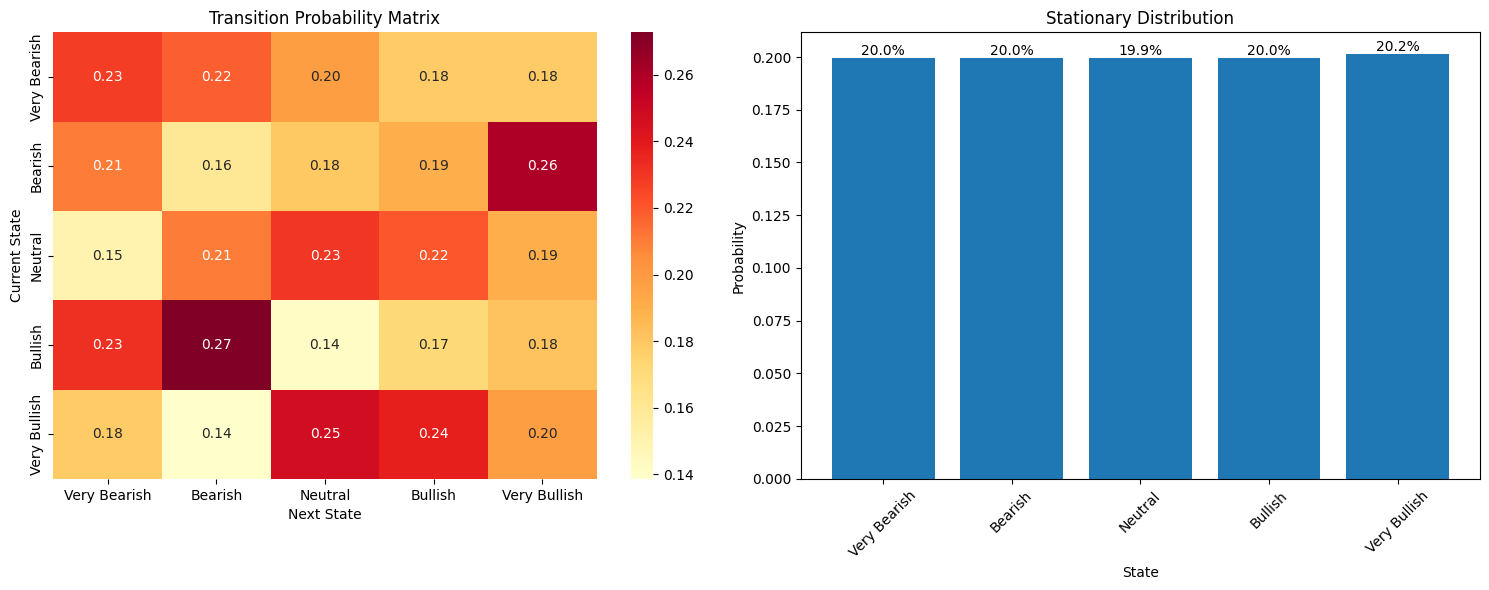


Markov Chain Analysis Complete.

Transition Matrix:
              Very Bearish   Bearish   Neutral   Bullish  Very Bullish
Very Bearish      0.227723  0.217822  0.198020  0.178218      0.178218
Bearish           0.210000  0.160000  0.180000  0.190000      0.260000
Neutral           0.150000  0.210000  0.230000  0.220000      0.190000
Bullish           0.232323  0.272727  0.141414  0.171717      0.181818
Very Bullish      0.178218  0.138614  0.247525  0.237624      0.198020

Stationary Distribution:
          State  Probability
0  Very Bearish     0.199616
1       Bearish     0.199703
2       Neutral     0.199484
3       Bullish     0.199585
4  Very Bullish     0.201611
Performed 1000 simulations for 100 days.


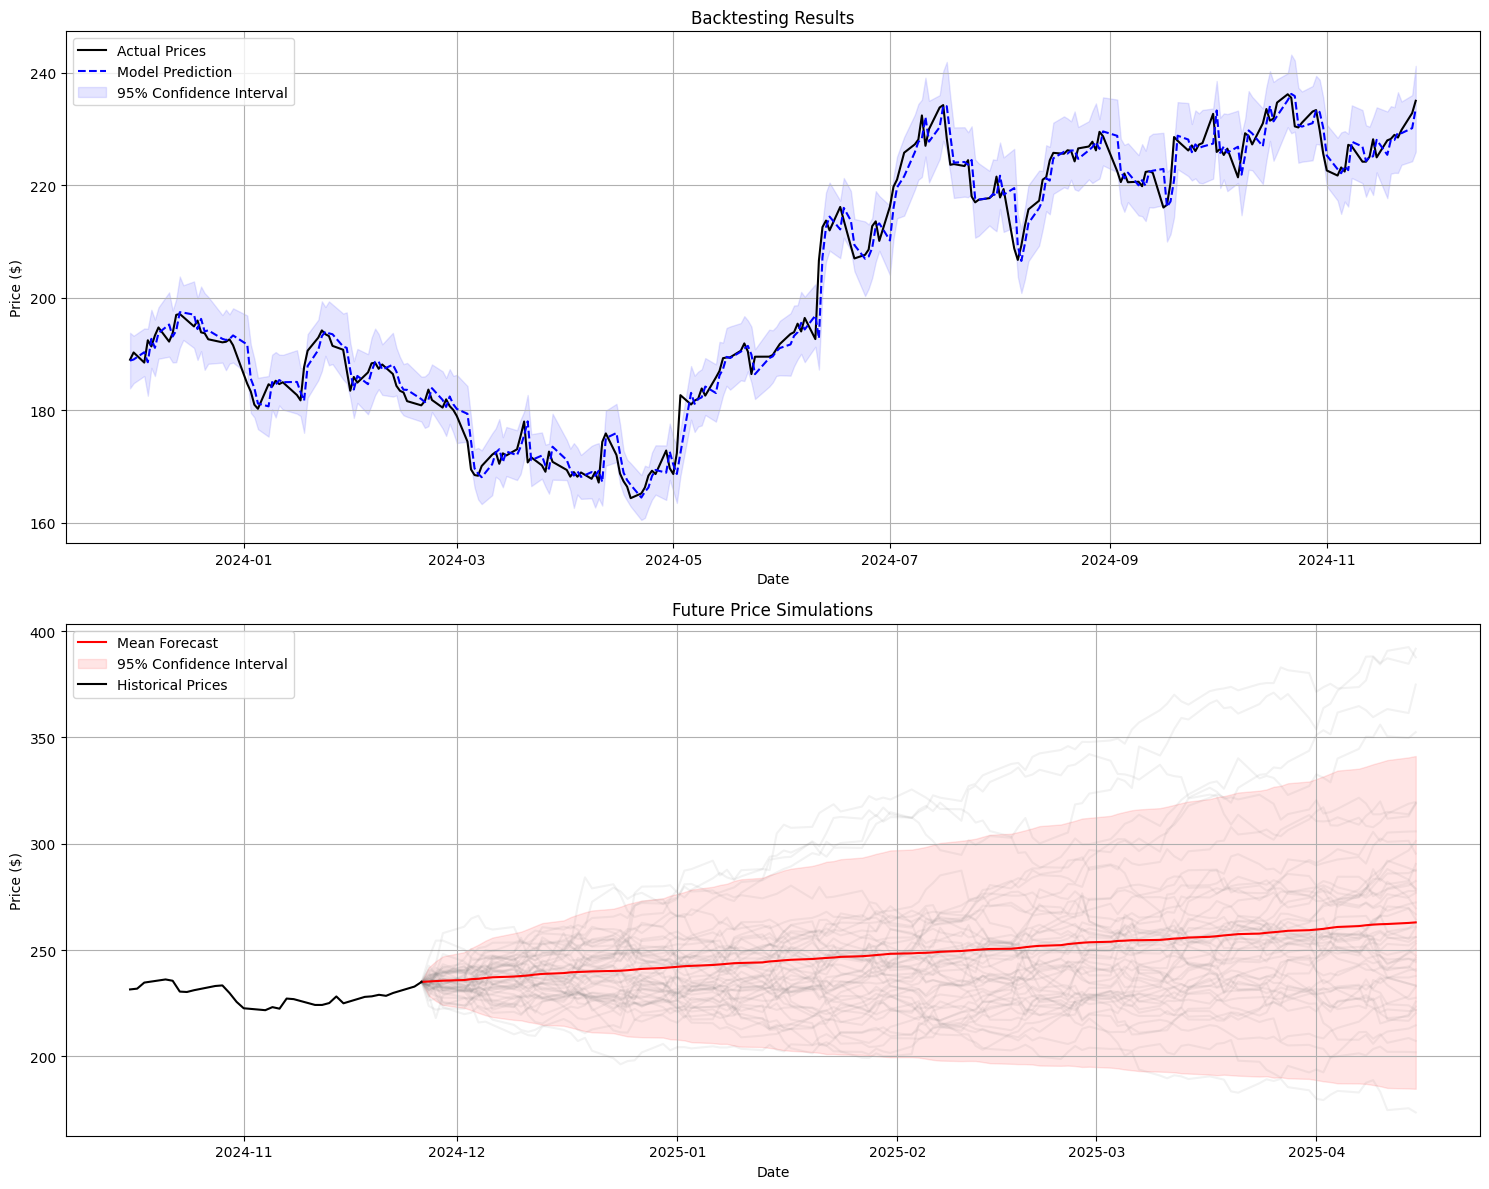


Future Prediction Statistics:
+---------------------------------------+-------------------+
| Metric                                | Value             |
|---------------------------------------+-------------------|
| Current Price                         | $235.06           |
| Predicted Price (in 100 days)         | $263.05           |
| Average Predicted Price (100 days)    | $263.05           |
| Prediction Range                      | $145.59 - $425.79 |
| Historical Volatility (%)             | 1.41%             |
| Simulated Volatility (%)              | 10.95%            |
| 90% Confidence Interval (Final Price) | $203.20 - $329.48 |
| 95% Confidence Interval (Final Price) | $196.56 - $347.90 |
+---------------------------------------+-------------------+


In [4]:
class StockDataAnalysis:
    def __init__(self, ticker, start_date, end_date, n_states=5):
        """
        Initialize the StockDataAnalysis with stock parameters and state count.
        
        Args:
            ticker (str): Stock ticker symbol.
            start_date (datetime): Start date for data retrieval.
            end_date (datetime): End date for data retrieval.
            n_states (int): Number of quantile-based states.
        """
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.n_states = n_states
        self.df = None
        self.transition_matrix = None

    def get_stock_data(self):
        """
        Download historical stock data from Yahoo Finance and preprocess it.
        """
        stock = yf.Ticker(self.ticker)
        df = stock.history(start=self.start_date, end=self.end_date)
        df['Daily_Return'] = df['Close'].pct_change() * 100 #TODO Extract the close price and calculate daily returns
        self.df = df.dropna()  #TODO Remove NaN values
        print(f"Stock data for {self.ticker} loaded successfully.")

    def assign_states(self):
        """
        Assign states based on return quantiles and add descriptive labels.
        """
        self.df['State'] = pd.qcut(self.df['Daily_Return'], q=self.n_states, labels=False)
        state_labels = ["Very Bearish", "Bearish", "Neutral", "Bullish", "Very Bullish"] #TODO Initialize state lables in a list in the order described in the question
        self.df['State_Description'] = pd.Categorical(
            [state_labels[int(i)] for i in self.df['State']]
        )
        print("States assigned based on quantiles.")

    def get_transition_matrix(self):
        """
        Construct the transition probability matrix from the sequence of states.
        
        Returns:
            np.array: Transition matrix (dimensions: n_states x n_states).
        
        TODO:
        - Ensure that states are properly handled as integers without NaNs.
        - Implement a loop or vectorized operation to count transitions between states.
        - Normalize the rows of the transition matrix to get probabilities.
        """
        # TODO: Extract the 'State' column from the DataFrame as a numpy array.
        states = self.df['State'].values # Ensure this is done without NaNs if needed.

        # Initialize a matrix to store transition counts.
        transitions = np.zeros((self.n_states, self.n_states)) 

        # TODO: Iterate through the array of states and populate the transition matrix.
        # Hint: Use a loop to increment the count for transitions from states[i] to states[i + 1].
        for i in range(len(states) - 1):
            current_state = states[i]  # Ensure valid integer index
            next_state = states[i + 1]  # Ensure valid integer index
            transitions[current_state][next_state] += 1  # Increment the count for observed transitions.

        
        epsilon = 1e-8
        row_sums = transitions.sum(axis=1) + epsilon

        # TODO: Normalize each row of the transition matrix to create probabilities.
        # Hint: Divide each element in a row by the sum of the row to ensure each row sums to 1.
        self.transition_matrix = transitions / row_sums[:, None]

        return self.transition_matrix


    def get_stationary_distribution(self):
        """
        Calculate the stationary distribution of the Markov chain.
        
        Returns:
            np.array: Stationary distribution (dimensions: n_states).
        """
        eigenvals, eigenvects = np.linalg.eig(self.transition_matrix.T) # TODO Calculate the eigenvalues and eigenvectors
        stationary = eigenvects[:, np.where(np.isclose(eigenvals, 1))[0][0]].real
        stationary = stationary / stationary.sum() #TODO Normalize the stationary distribution
        print("Stationary distribution calculated.")
        return stationary

    def analyze_markov_chain(self):
        """
        Analyze and visualize Markov chain properties.
        """
        stationary_dist = self.get_stationary_distribution() # TODO Calculate the stationary distribution
        state_labels = ["Very Bearish", "Bearish", "Neutral", "Bullish", "Very Bullish"] #TODO Initialize state lables in a list in the order described in the question

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        sns.heatmap(self.transition_matrix, annot=True, fmt='.2f', cmap='YlOrRd', ax=ax1,
                    xticklabels=state_labels, yticklabels=state_labels)
        ax1.set_title('Transition Probability Matrix')
        ax1.set_xlabel('Next State')
        ax1.set_ylabel('Current State')

        bars = ax2.bar(state_labels, stationary_dist)
        ax2.set_title('Stationary Distribution')
        ax2.set_xlabel('State')
        ax2.set_ylabel('Probability')
        ax2.tick_params(axis='x', rotation=45)

        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width() / 2., height,
                     f'{height * 100:.1f}%', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

        print("\nMarkov Chain Analysis Complete.")
        print("\nTransition Matrix:")
        transition_df = pd.DataFrame(self.transition_matrix,
                                     columns=state_labels,
                                     index=state_labels)
        print(transition_df)

        print("\nStationary Distribution:")
        stationary_df = pd.DataFrame({
            'State': state_labels,
            'Probability': stationary_dist
        })
        print(stationary_df)

    def simulate_price_path(self, initial_price, days):
        """
        Simulate a single price path using the Markov chain model.
        
        Args:
            initial_price (float): Starting price for the simulation.
            days (int): Number of days to simulate.
        
        Returns:
            np.array: Simulated price path.
        
        TODO:
        - Implement the logic for price path simulation based on state transitions.
        """
        prices = [initial_price]
        current_state = np.random.choice(self.n_states)

        for _ in range(days):
            next_state = np.random.choice(self.n_states, p=self.transition_matrix[current_state])
            return_pct = np.random.choice(self.df[self.df['State'] == next_state]['Daily_Return'])
            next_price = prices[-1] * (1 + return_pct / 100)
            prices.append(next_price)
            current_state = next_state

        return np.array(prices)

    def perform_simulations(self, n_simulations=1000, forecast_days=100):
        """
        Perform multiple price simulations using the Markov model.
        
        TODO:
        - Store and return simulation results.
        """
        initial_price = self.df['Close'].iloc[-1] 

        simulations = np.zeros((n_simulations, forecast_days + 1))

        for i in range(n_simulations):
            simulations[i] = self.simulate_price_path(initial_price, forecast_days) #TODO call the simulate_price_path method

        print(f"Performed {n_simulations} simulations for {forecast_days} days.")
        return simulations

    def backtest(self, n_simulations=100):
        """
        Perform walk-forward backtesting using the Markov model.
        
        TODO:
        - Implement rolling window logic to create a dynamic transition matrix for each backtest step.
        - Ensure return distributions are created for each state within the rolling window.
        - Simulate next-day prices using the dynamic transition matrix and return distributions.
        """
        window_size = 252  # One trading year
        n_states = self.transition_matrix.shape[0]
        predictions = np.zeros((len(self.df), n_simulations))

        # TODO: Iterate through the dataset, starting from the end of the initial rolling window.
        for i in range(window_size, len(self.df)):
            # TODO: Extract a rolling window of the data to calculate the transition matrix.
            # Hint: Use `iloc` to get rows from `i - window_size` to `i`.
            window_data = self.df.iloc[i - window_size:i]

            # Check if the window data has enough valid states to build a transition matrix.
            if window_data['State'].isna().any() or len(window_data['State'].unique()) < n_states: 
                continue

            # TODO: Create a transition matrix from the rolling window data.
            # Hint: Call a function like `get_transition_matrix` with the states in `window_data`.
            window_transitions = self.get_transition_matrix()
            
            # Create return distributions for each state, ensuring non-empty arrays
            returns_by_state = [
                window_data[window_data['State'] == state]['Daily_Return'].values
                for state in range(n_states)
            ]

            # TODO: Simulate next-day prices using the current price and the transition matrix.
            # Hint: Use `simulate_price_path` for the simulation.
            current_price = self.df['Close'].iloc[i - 1]
            for sim in range(n_simulations):
                sim_path = self.simulate_price_path(current_price, 1)
                predictions[i, sim] = sim_path[-1]

        # TODO: Return or process the predictions as needed for analysis.
        valid_indices = np.where(predictions.sum(axis=1) != 0)[0]
        prediction_mean = np.mean(predictions[valid_indices], axis=1)
        prediction_std = np.std(predictions[valid_indices], axis=1)
        lower_bound = prediction_mean - 1.96 * prediction_std
        upper_bound = prediction_mean + 1.96 * prediction_std

        return prediction_mean, lower_bound, upper_bound


    def plot_results(self, simulations, backtest_results):
        """
        Create visualization of historical prices, backtest results, and future simulations.
        """
        prediction_mean, lower_bound, upper_bound = backtest_results

        # Adjust the prediction arrays to match the index length
        valid_index = len(prediction_mean)
        df_index_subset = self.df.index[-valid_index:]

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

        # Plot backtesting results
        ax1.plot(df_index_subset, self.df['Close'].iloc[-valid_index:], color='black', label='Actual Prices')
        ax1.plot(df_index_subset, prediction_mean, color='blue', linestyle='--', label='Model Prediction')
        ax1.fill_between(df_index_subset, lower_bound, upper_bound, color='blue', alpha=0.1, label='95% Confidence Interval')
        ax1.set_title('Backtesting Results')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Price ($)')
        ax1.legend()
        ax1.grid(True)


        # Plot future simulations
        future_dates = pd.date_range(
            self.df.index[-1], 
            periods=simulations.shape[1], 
            freq='B'
        )

        # Plot individual simulations
        for sim in simulations[:50]:   # Plot first 50 simulations for clarity
            ax2.plot(future_dates, sim, alpha=0.1, color='gray')

        # Plot confidence intervals for simulation 
        sim_mean = np.mean(simulations, axis=0)
        sim_std = np.std(simulations, axis=0)
        ax2.plot(future_dates, sim_mean, color='red', label='Mean Forecast')
        ax2.fill_between(
            future_dates,
            sim_mean - 1.96 * sim_std,
            sim_mean + 1.96 * sim_std,
            color='red',
            alpha=0.1,
            label='95% Confidence Interval'
        )

        # Plot historical prices for context
        ax2.plot(self.df.index[-30:], self.df['Close'][-30:], color='black', label='Historical Prices')

        ax2.set_title('Future Price Simulations')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Price ($)')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

    def generate_summary_stats(self, simulations, current_price):
        """
        Generate and display summary statistics for future price simulations using tabulate.
        """
        # Calculate average predicted price
        final_prices = simulations[:, -1]
        mean_final_price = np.mean(final_prices)
        min_final_price = np.min(final_prices)
        max_final_price = np.max(final_prices)

        # Calculate prediction intervals
        lower_90 = np.percentile(final_prices, 5)
        upper_90 = np.percentile(final_prices, 95)
        lower_95 = np.percentile(final_prices, 2.5)
        upper_95 = np.percentile(final_prices, 97.5)

        # Calculate simulated volatility
        simulated_volatility = np.std(simulations) / np.mean(simulations) * 100

        # Historical volatility (standard deviation of daily returns)
        historical_volatility = self.df['Daily_Return'].std()
        
        # Create the summary statistics table
        summary_stats = [
            ['Current Price', f"${current_price:.2f}"],
            ['Predicted Price (in 100 days)', f"${mean_final_price:.2f}"],
            ['Average Predicted Price (100 days)', f"${np.mean(final_prices):.2f}"],
            ['Prediction Range', f"${min_final_price:.2f} - ${max_final_price:.2f}"],
            ['Historical Volatility (%)', f"{historical_volatility:.2f}%"],
            ['Simulated Volatility (%)', f"{simulated_volatility:.2f}%"],
            ['90% Confidence Interval (Final Price)', f"${lower_90:.2f} - ${upper_90:.2f}"],
            ['95% Confidence Interval (Final Price)', f"${lower_95:.2f} - ${upper_95:.2f}"]
        ]
        
        # Print the summary statistics using tabulate
        print("\nFuture Prediction Statistics:")
        return tabulate(summary_stats, headers=['Metric', 'Value'], tablefmt='psql')
     


if __name__ == "__main__":
    ticker = "AAPL"  #TODO replace with Apple Inc. ticker
    end_date = datetime.now()
    start_date = end_date - timedelta(days=2 * 365)

    stock_analysis = StockDataAnalysis(ticker, start_date, end_date)

    stock_analysis.get_stock_data()
    stock_analysis.assign_states()
    stock_analysis.get_transition_matrix()
    stock_analysis.analyze_markov_chain()

    simulations = stock_analysis.perform_simulations(n_simulations=1000, forecast_days=100)
    backtest_results = stock_analysis.backtest(n_simulations=100)

    # TODO: Call plot_results and generate_summary_stats methods
    stock_analysis.plot_results(simulations, backtest_results)
    current_price = stock_analysis.df['Close'].iloc[-1]  # Extract the current closing stock price 
    print(stock_analysis.generate_summary_stats(simulations, current_price))   
